In [1]:
import torch
import torch.nn as nn
from scipy.io import loadmat
datafold='/Users/user/PycharmProjects/PacManMain/data/ContinuousDecode/'
X_data=loadmat(datafold+'X_data.mat')['Xt1']
Y_data=loadmat(datafold+'Y_data.mat')['YTrain']



# Convert to PyTorch tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
Y_tensor = torch.tensor(Y_data, dtype=torch.float32)

# Splitting data into training and test sets
train_size = int(0.7 * X_tensor.size(1))  # 70% of trials for training
X_train, Y_train = X_tensor[:, :train_size, :], Y_tensor[:, :train_size]
X_test, Y_test = X_tensor[:, train_size:, :], Y_tensor[:, train_size:]



In [2]:
class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNDecoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM layer
        # x shape: (batch, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # Fully connected layer
        predictions = self.fc(lstm_out)
        return predictions

# Assuming 50 neurons and predicting 1 continuous variable at each time step
input_size = 48
hidden_size = 100  # You can tune this
output_size = 1

model = RNNDecoder(input_size, hidden_size, output_size)


In [4]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training loop
num_epochs = 60  # You can tune this
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output,Y_train.transpose(1, 0))

    l1_lambda = 1e-5  # Regularization strength

    # Assuming you are inside your training loop and have calculated 'loss'
    l1_norm = sum(p.abs().sum() for p in model.parameters())

    # Add the L1 penalty to the original loss
    total_loss = loss + l1_lambda * l1_norm

    total_loss.backward()

    #loss.backward()
    optimizer.step()

    if epoch % 2 == 0:  # Print loss every 2 epochs
        print(f'Epoch {epoch}, Loss: {total_loss.item()}')

Epoch 0, Loss: 0.1805693507194519
Epoch 2, Loss: 0.17969800531864166
Epoch 4, Loss: 0.18085329234600067
Epoch 6, Loss: 0.17811860144138336
Epoch 8, Loss: 0.17801639437675476
Epoch 10, Loss: 0.1769932210445404
Epoch 12, Loss: 0.17576146125793457
Epoch 14, Loss: 0.17555952072143555
Epoch 16, Loss: 0.1744498312473297
Epoch 18, Loss: 0.1737518161535263
Epoch 20, Loss: 0.173303484916687
Epoch 22, Loss: 0.1723944991827011
Epoch 24, Loss: 0.17189711332321167
Epoch 26, Loss: 0.17130997776985168
Epoch 28, Loss: 0.17061206698417664
Epoch 30, Loss: 0.1701582968235016
Epoch 32, Loss: 0.1695345938205719
Epoch 34, Loss: 0.16901059448719025
Epoch 36, Loss: 0.1685160994529724
Epoch 38, Loss: 0.16795989871025085
Epoch 40, Loss: 0.1675087958574295
Epoch 42, Loss: 0.16699165105819702
Epoch 44, Loss: 0.16654406487941742
Epoch 46, Loss: 0.16607794165611267
Epoch 48, Loss: 0.16563673317432404
Epoch 50, Loss: 0.16520433127880096
Epoch 52, Loss: 0.16478382050991058
Epoch 54, Loss: 0.16437900066375732
Epoch 56

In [5]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, Y_test.transpose(1,0))
    print(f'Test Loss: {test_loss.item()}')

Test Loss: 0.1528468281030655


/Users/user/anaconda3/envs/main/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([19, 30])) that is different to the input size (torch.Size([30, 19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


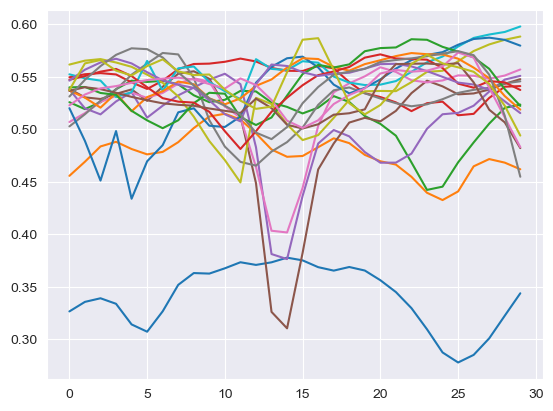

In [6]:
import matplotlib.pyplot as plt
plt.plot(predictions.detach().numpy()[:,:,0])